In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        #record the number of trials for each arm
        self.ntrial = np.zeros(narms,dtype=int) 
        #record the up-to-date Q-value of each arm,initially Q0
        self.Q_value = np.full(self.narms, self.Q0, dtype=float) 
        
    def play(self, tround, context=None):
        #the index of arm selected in this round
        selected_arm = 0 
        if np.random.random() < self.epsilon:
            #explore: randomly choose an arm
            selected_arm = np.random.choice(self.narms)
        else:
            #exploit: choose an arm with the maximum Q-value
            selected_arm = np.random.choice(np.argwhere(self.Q_value==self.Q_value.max()).flatten())
        return selected_arm
    
    def update(self, arm, reward, context=None):
        #update the number of trials of the selected arm
        self.ntrial[arm] += 1 
        #update the Q-value of the selected arm
        #Note that the first trial of each arm should be considered seperately to avoid the problem of np.inf (np.inf * 0 = nan)
        self.Q_value[arm] =  ((self.ntrial[arm] - 1) * self.Q_value[arm] + reward) / self.ntrial[arm] if self.ntrial[arm] > 1 else reward 

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.ntrial = np.zeros(narms,dtype=int) #record the number of trials for each arm
        self.avg_reward = np.full(self.narms, self.Q0, dtype=float) #record the average reward of each arm
        
    def play(self, tround, context=None):
        #compute the Q-value of wach arm
        #Noting that after each round the Q-value will be updated for every arm based on tround no matter whether it is selected in this round
        Q_value = np.array([self.avg_reward[i] + self.calcu_confidence_interval(i,tround) for i in range(self.narms)])
        #choose the index of the arm with the maximum Q-value
        selected_arm = np.random.choice(np.argwhere(Q_value==Q_value.max()).flatten())
        return selected_arm
        
    def update(self, arm, reward, context=None):
        #update the number of trials of the selected arm
        self.ntrial[arm] += 1 
        #update the average reward of the selected arm
        #Note that the first trial of each arm should be considered seperately to avoid the problem of np.inf (np.inf * 0 = nan)
        self.avg_reward[arm] = ((self.ntrial[arm] - 1) * self.avg_reward[arm] + reward) / self.ntrial[arm] if self.ntrial[arm] > 1 else reward 
        
    def calcu_confidence_interval(self, arm, tround):
        '''
        A helper function that calulates the upper confidence interval for Q estimates
        '''
        if self.ntrial[arm] == 0:
            return 0
        else:
            return np.sqrt(self.rho * np.log(tround) / self.ntrial[arm])
        

## 2. The Basic Thompson Bandit

In [7]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        #record the alpha parameter of each arm
        self.alpha = np.full(self.narms, self.alpha0, dtype=float) 
        #record the beta parameter of each arm
        self.beta = np.full(self.narms, self.beta0, dtype=float) 
        
        
    def play(self, tround, context=None):
        #sample from Beta distribution of each arm
        theta = np.random.beta(self.alpha, self.beta) 
        #select the arm with the maximum theta
        selected_arm = np.random.choice(np.argwhere(theta==theta.max()).flatten()) 
        return selected_arm
    
    def update(self, arm, reward, context=None):
        #update the posterior (i.e., alpha and beta parameter) from (alpha,beta) to (alpha+reward,beta+1-reward)
        self.alpha[arm] += reward
        self.beta[arm] += 1-reward

## 3. Off-Policy Evaluation

In [8]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    #An initial zero total payoff
    R = np.zeros(nrounds, np.float)
    #An initially empty history 
    history = []
    try:
        # the iterator of T(i.e., nround)
        t = 0   
        # iterator of arm, reward and context in the event log
        arm_iter = iter(arms)
        reward_iter = iter(rewards)
        context_iter = iter(contexts)
        #the arm selected by the bandit
        selected_arm = 0
        for t in range(nrounds):
            arm = next(arm_iter)
            reward = next(reward_iter)
            context = next(context_iter)
            #Note that a bandit may play different arms for different events,so each event needs to call play() once
            selected_arm = mab.play(t + 1, context) + 1
            #repeat the event util matching the expected arm
            while selected_arm != arm:
                arm = next(arm_iter)
                reward = next(reward_iter)
                context = next(context_iter)
                #Note that a bandit may play different arms for different events,so each event needs to call play() once
                selected_arm = mab.play(t + 1, context) + 1
            #concatenate the history information
            history.append((context,arm,reward))
            #choose the selected arm and update the reward information
            mab.update(selected_arm - 1, reward, context)
            R[t] += reward
    except:
        #store the current result to avoid insufficient log events
        print("overflow")
        R = R[:t] 
    #note that the final cumulative reward needs to divide by T,which has been implemented by np.mean(R)
    return R 

Read the file and extract arms, rewards, and contexts

In [9]:
data = np.loadtxt("dataset.txt", np.int)
arms, rewards, contexts = data[:, 0], data[:, 1], data[:, 2:]

In [18]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18375


In [11]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.155


In [19]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.23375


## 4. Contextual Bandits - LinUCB

In [20]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        #A is a narms * ndims * ndims dimensional matrix, and each arm corresponds to a ndims-dimensional identity matrix
        self.A = np.array([np.identity(ndims) for i in range(narms)])
        #b is a narms * ndims dimensional matrix, and each arm corresponds to a ndims-dimensional zero vector (i.e., response vector)
        self.b = np.array([np.zeros(ndims) for i in range(narms)])
        
    def play(self, tround, context):
        #set theta, which is equal to (A^-1 * b)
        theta = np.array([np.dot(np.linalg.inv(self.A[i]),self.b[i]) for i in range(self.narms)])
        #reshape the context to narms*ndims dimension
        context_reshape = context.reshape(self.narms,self.ndims)
        #init the p array
        p = np.zeros(self.ndims)
        #calculate the p value of each arm in the algorithm 
        for i in range(self.narms):
            #calculate the expected payoff (i.e., theta^T * context)
            expected_payoff = np.dot(theta[i].T,context_reshape[i])
            #calcuate the standard deviation of the expected payoff (i.e., sqrt(context^T * A * context))
            deviation = np.sqrt(context_reshape[i].T.dot(np.linalg.inv(self.A[i])).dot(context_reshape[i]))
            #p value = expected_payoff + alpha * standard deviation
            p[i] = expected_payoff + self.alpha * deviation
        #choose the arm with the maximum p-value
        selected_arm = np.random.choice(np.argwhere(p==p.max()).flatten()) 
        return selected_arm
    
    def update(self, arm, reward, context):
        #reshape the context to narms*ndims dimension
        context_reshape = context.reshape(self.narms,self.ndims)
        #extract the feature vector of the corresponding arm
        context = context_reshape[arm]
        #update A by context*context^T, note that reshape is required to transform the one-dimension array to 1*d dimensional vector
        self.A[arm] += np.dot(context.reshape(1,self.ndims).T,context.reshape(1,self.ndims))
        #update b by rewart*context
        self.b[arm] += reward * context


In [21]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [22]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms = narms
        self.ndims = ndims
        self.v = v
        # init the B in the algorithm
        self.B =np.identity(ndims)
        #init an array f = sigma(context*reward) , so that u=B(t)^-1 * f(t)
        self.f = np.zeros(ndims)
        
    def play(self, tround, context):
        #compute mu, which equals to B(t)^-1 * f(t)
        mu = np.dot(np.linalg.inv(self.B),self.f)
        #sample from N(mu,v^2 * B^-1), note that multivariate normal is needed instead of traditional normal
        sample_mu = np.random.multivariate_normal(mu, (self.v**2) * np.linalg.inv(self.B))
        #reshape the context to narms*ndims dimension
        context_reshape = context.reshape(self.narms,self.ndims) 
        #compute (context^T * sample_mu)
        value = np.array([np.dot(context_reshape[i].T,sample_mu) for i in range(self.narms)])
        #choose the arm with the maximum value
        selected_arm =  np.random.choice(np.argwhere(value==value.max()).flatten())
        return selected_arm
    
    def update(self, arm, reward, context): 
        #reshape the context to narms*ndims dimension
        context_reshape = context.reshape(self.narms,self.ndims)
        #update B by context*context^T
        self.B += np.dot(context_reshape[arm].reshape(1,10).T,context_reshape[arm].reshape(1,10))
        #update f by context * reward
        self.f += context_reshape[arm] * reward
    

In [24]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.315


## 6. Evaluation
### 6.A.

EpsGreedy average reward 0.18625
UCB average reward 0.16125
BetaThompson average reward 0.2125
LinUCB average reward 0.53
LinThompson average reward 0.3075


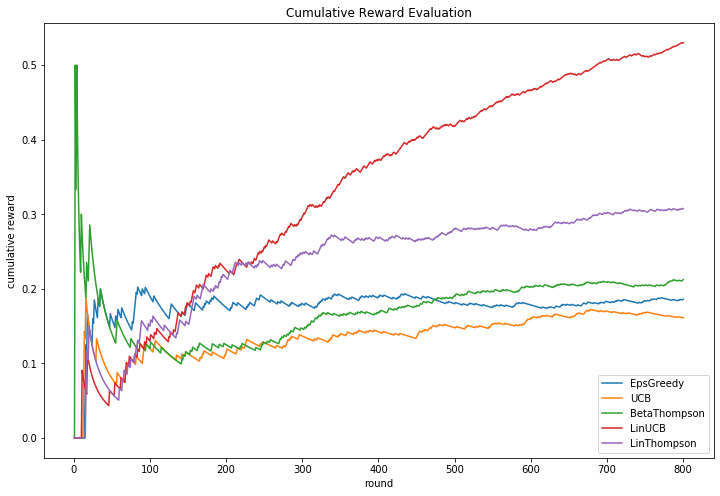

In [25]:
# Run offlineEvaluate on each of the bandits
mab_EpsGreedy = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab_EpsGreedy, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

mab_UCB = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab_UCB, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

mab_BetaThompson = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab_BetaThompson, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

mab_LinUCB = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

mab_LinThompson = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab_LinThompson, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

def cal_cumulative_reward(result):
    '''
        A helper function to calculate the cumulative result
    '''
    cumsum_result = np.cumsum(result)
    cumsum_result = [cumsum_result[i]/(i+1) for i in range(len(result))]
    return cumsum_result

#start plotting
plt.figure(figsize=(12,8))
plt.title('Cumulative Reward Evaluation')

x_axis = [i for i in range(1,len(results_EpsGreedy)+1)]
plt.plot(x_axis,cal_cumulative_reward(results_EpsGreedy),label="EpsGreedy")
x_axis = [i for i in range(1,len(results_UCB)+1)]
plt.plot(x_axis,cal_cumulative_reward(results_UCB),label="UCB")
x_axis = [i for i in range(1,len(results_BetaThompson)+1)]
plt.plot(x_axis,cal_cumulative_reward(results_BetaThompson),label="BetaThompson")
x_axis = [i for i in range(1,len(results_LinUCB)+1)]
plt.plot(x_axis,cal_cumulative_reward(results_LinUCB),label="LinUCB")
x_axis = [i for i in range(1,len(results_LinThompson)+1)]
plt.plot(x_axis,cal_cumulative_reward(results_LinThompson),label="LinThompson")

plt.legend()
plt.xlabel('round')
plt.ylabel('cumulative reward')
plt.show()

### 6.B.

Grid Search For LinUCB

The maximum average reward is 0.73125, and the corresponding alpha is 0.02004008016032064


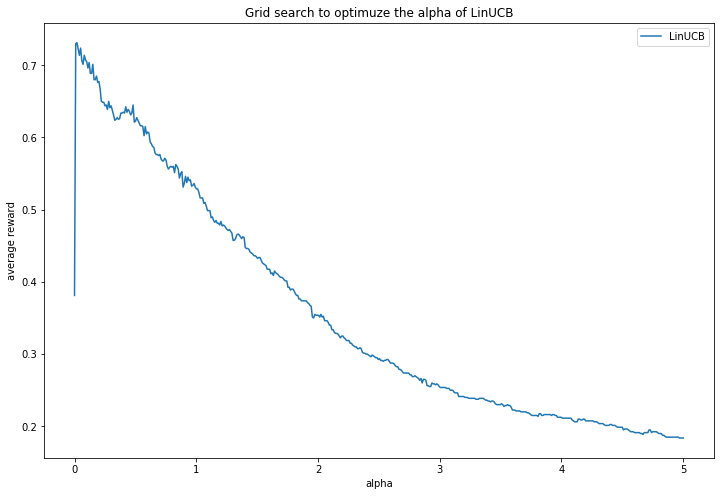

In [28]:
#generate 500 evenly spaced numbers from 0 to 5
alpha_candidates = np.linspace(0, 5, num=500)
#record the results of different alphas
results = np.zeros(len(alpha_candidates))
#do the grid search
for i in range(len(alpha_candidates)):
    mab = LinUCB(10, 10, alpha_candidates[i])
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results[i] = np.mean(results_LinUCB)
max_index = np.argmax(results)
print("The maximum average reward is %s, and the corresponding alpha is %s" %(results[max_index],alpha_candidates[max_index]))
#start plotting
plt.figure(figsize=(12,8))
plt.title('Grid search to optimuze the alpha of LinUCB')
plt.plot(alpha_candidates,results,label="LinUCB")

plt.legend()
plt.xlabel('alpha')
plt.ylabel('average reward')
plt.show()

Grid Search For LinThompson

The maximum average reward is 0.47375, and the corresponding v is 0.1002004008016032


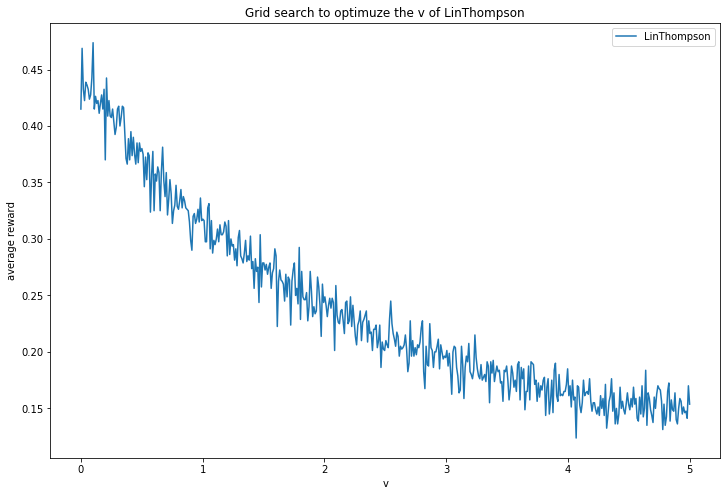

In [29]:
#generate 500 evenly spaced numbers from 0 to 5
v_candidates = np.linspace(0, 5, num=500)
#record the results of different v-values
results = np.zeros(len(v_candidates))
#do the grid search
for i in range(len(v_candidates)):
    mab = LinThompson(10, 10, v_candidates[i])
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results[i] = np.mean(results_LinThompson)
max_index = np.argmax(results)
print("The maximum average reward is %s, and the corresponding v is %s" %(results[max_index],v_candidates[max_index]))
#start plotting
plt.figure(figsize=(12,8))
plt.title('Grid search to optimuze the v of LinThompson')
plt.plot(alpha_candidates,results,label="LinThompson")

plt.legend()
plt.xlabel('v')
plt.ylabel('average reward')
plt.show()